In [20]:
import json
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats.distributions import norm
from scipy.optimize import fmin
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
#from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [189]:
df = pd.read_csv("crop_county_data.csv")

In [191]:
df[df.value == '                 (D)'] = np.NaN
df.dropna()
#df['value'] = df['value'].str.replace(',','')
#print(df.tail())
df['value'] = df['value'].astype('float64')
#df.head()

In [192]:
"""county_dict is a dictionary containing the name of the county as the key and a dataframe for the county as a value"""
county_dict = {}
for county in df.county_name.unique():
    data = df[df['county_name']==county]
    county_dict.update({county:data})
def splitter(county,year_max,year_min,crop,desc=None):
    sub = county_dict[county]
    if crop == "OTHERS": #This doesn't work yet
        if desc != None:
            crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] != "WHEAT") & (sub['commodity_desc'] != "CORN") & (sub['short_desc'] == desc)]
        else:
            crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] != "WHEAT") & (sub['commodity_desc'] != "CORN")]
    else:
        if desc != None:
            crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] == crop) & (sub['short_desc'] == desc)]
        else:
            crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] == crop)]
    for i in np.unique(crop['year']):
        drops = crop[crop['year']==i].index
        if len(drops) > 1:
            crop.drop(drops[1:],inplace=True) #From 2008 on the data doesn't have a good total row, so you can't just use short_desc to get the data after trying several things I decided that it is late and I should just use the first row that is the total when it exists and it is the better option if it doesn't.
    crop.set_index('year',inplace = True)
    return crop

In [206]:
adams = splitter("ADAMS",2020,1900,"WHEAT")
adams2 = splitter("ADAMS",2020,1900,"CORN")
adams4 = splitter("ADAMS",2020,1900,"SOYBEANS")
#adams3 = splitter("ADAMS",2020,1900,"OTHERS") #Others doesn't do what I want yet, I want to sub all not wheat/corn, but it is weird with the dirty data

In [195]:
order = order_select(adams[['value']],max_ar=5,max_ma=5,ic=['aic','bic'],fit_kw={'method':'mle'})

In [196]:
order2 = order_select(adams2[['value']],max_ar=5,max_ma=5,ic=['aic','bic'],fit_kw={'method':'mle'})
#order3 = order_select(adams3[['value']],max_ar=5,max_ma=5,ic=['aic','bic'],fit_kw={'method':'mle'})

In [208]:
order4 = order_select(adams4[['value']],max_ar=5,max_ma=5,ic=['aic','bic'],fit_kw={'method':'mle'})

In [209]:
print(order['bic_min_order'])
print(order2['bic_min_order'])
#print(order3['bic_min_order'])
print(order4['bic_min_order'])

(2, 0)
(1, 0)
(3, 0)


In [198]:
# Fit model
model = ARMA(adams[['value']], order['bic_min_order']).fit(method='mle')

In [199]:
# Fit model
model2 = ARMA(adams2[['value']], order2['bic_min_order']).fit(method='mle')
#model3 = ARMA(adams3[['value']], order3['bic_min_order']).fit(method='mle')

In [210]:
# Fit model
model4 = ARMA(adams4[['value']], order2['bic_min_order']).fit(method='mle')

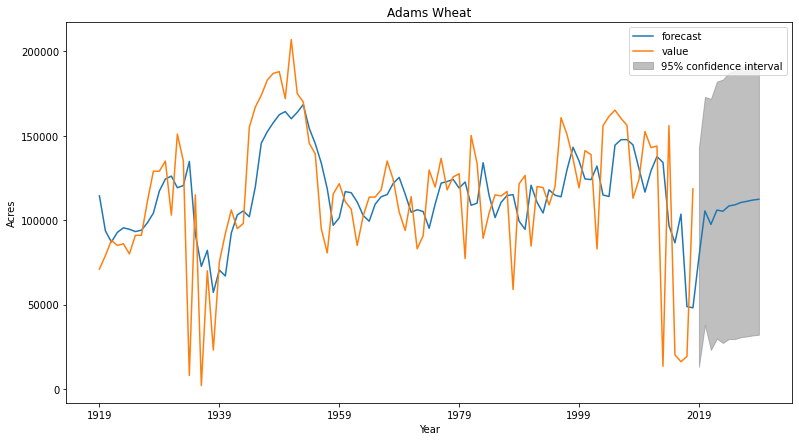

In [213]:
# Create plot
fig, ax = plt.subplots(figsize=(13,7))
# Plot
fig = model.plot_predict(start=0, end=110, ax=ax)
ax.set_title('Adams Wheat')
plt.xticks([0,20,40,60,80,100],[1919,1939,1959,1979,1999,2019])
ax.set_xlabel('Year')
ax.set_ylabel('Acres')
plt.show()

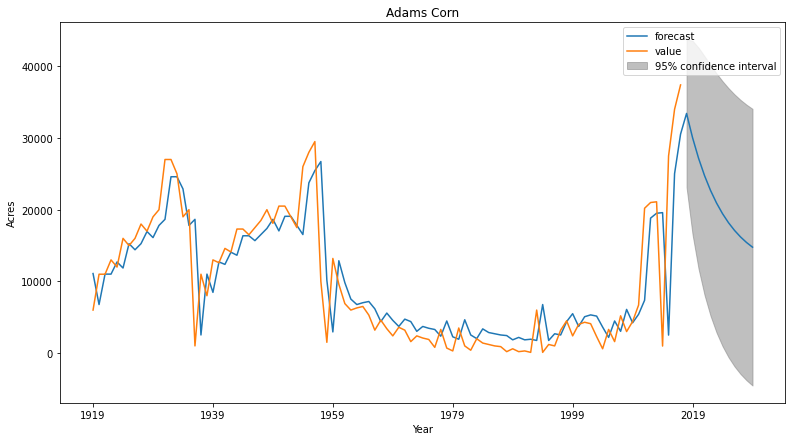

In [215]:
# Create plot
fig, ax = plt.subplots(figsize=(13,7))
# Plot
fig = model2.plot_predict(start=0, end=110, ax=ax)
ax.set_title('Adams Corn')
plt.xticks([0,20,40,60,80,100],[1919,1939,1959,1979,1999,2019])
ax.set_xlabel('Year')
ax.set_ylabel('Acres')
plt.show()

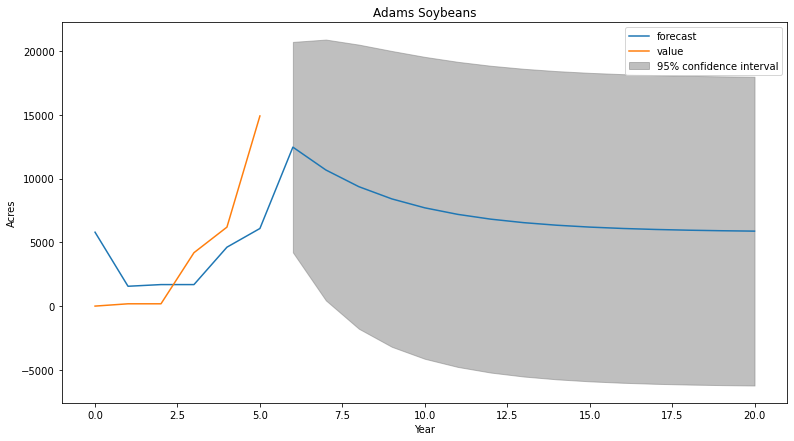

In [212]:
# Create plot
fig, ax = plt.subplots(figsize=(13,7))
# Plot
fig = model4.plot_predict(start=0, end=20, ax=ax)
ax.set_title('Adams Soybeans')
#plt.xticks([0,20,40,60,80,100],[1919,1939,1959,1979,1999,2019])
ax.set_xlabel('Year')
ax.set_ylabel('Acres')
plt.show()

In [214]:
adams2

,Unnamed: 0,fips_code,state_alpha,county_name,commodity_desc,unit_desc,value,short_desc
year,,,,,,,,
1919.0,1.0,38001.0,ND,ADAMS,CORN,ACRES,6000.0,"CORN, GRAIN - ACRES HARVESTED"
1920.0,371.0,38001.0,ND,ADAMS,CORN,ACRES,11000.0,"CORN, GRAIN - ACRES HARVESTED"
1921.0,742.0,38001.0,ND,ADAMS,CORN,ACRES,11000.0,"CORN, GRAIN - ACRES HARVESTED"
1922.0,1113.0,38001.0,ND,ADAMS,CORN,ACRES,13000.0,"CORN, GRAIN - ACRES HARVESTED"
1923.0,1484.0,38001.0,ND,ADAMS,CORN,ACRES,12000.0,"CORN, GRAIN - ACRES HARVESTED"
...,...,...,...,...,...,...,...,...
2014.0,100584.0,38001.0,ND,ADAMS,CORN,ACRES,21100.0,"CORN, GRAIN - ACRES HARVESTED"
2015.0,101037.0,38001.0,ND,ADAMS,CORN,ACRES,980.0,"CORN, SILAGE - ACRES HARVESTED"
2016.0,101411.0,38001.0,ND,ADAMS,CORN,ACRES,27500.0,"CORN, GRAIN - ACRES HARVESTED"
